In [1]:
from pathlib import Path

import pandas as pd
import torch
import scanpy as sc
import umap.plot
from rdkit import Chem
import matplotlib
import seaborn as sn
import matplotlib.pyplot as plt

from compert.embedding import get_chemical_representation

# To set some sane defaults
matplotlib.style.use("fivethirtyeight")
matplotlib.style.use("seaborn-talk")
matplotlib.rcParams['font.family'] = "monospace"
matplotlib.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.facecolor'] = 'white'
sn.set_context("poster")

embedding_dir = Path.cwd().parent / "embeddings"
data_dir = Path.cwd().parent / "datasets"
print("EMBEDDING DIR:", embedding_dir)
print("DATA DIR:", data_dir)

EMBEDDING DIR: /home/simon/Documents/ETH/Masters_thesis/chemical_CPA/embeddings
DATA DIR: /home/simon/Documents/ETH/Masters_thesis/chemical_CPA/datasets


In [2]:
anndata = sc.read(data_dir / "trapnell_cpa.h5ad")

In [3]:
smiles_to_pathway_map = {Chem.CanonSmiles(smiles): pathway for smiles, pathway in
                         anndata.obs.groupby(["SMILES", "pathway_level_1"]).groups.keys()}

In [4]:
canon_smiles = list(smiles_to_pathway_map.keys())
print(canon_smiles[:10])

['c1ccc2c(CCNc3ccc(Nc4ccncc4)cc3)c[nH]c2c1', 'CC(=O)Nc1ccc(C(=O)Nc2ccccc2N)cc1', 'CC(=O)Nc1ccc(OCC(C)(O)C(=O)Nc2ccc([N+](=O)[O-])c(C(F)(F)F)c2)cc1', 'CC(C)(CNC(=O)c1cccc(-c2noc(C(F)(F)F)n2)c1)c1coc(-c2ccccc2)n1', 'Cc1nnc(C(C)C)n1C1CC2CCC(C1)N2CCC(NC(=O)C1CCC(F)(F)CC1)c1ccccc1', 'CC(C)[C@H](C(=O)Nc1ccc(C(=O)NO)cc1)c1ccccc1', 'CC(c1cc2ccccc2s1)N(O)C(N)=O', 'CC(NC(=O)c1ccccc1/N=C/c1c(O)ccc2ccccc12)c1ccccc1', 'Cc1cc(C(C)Nc2ccccc2)c2nc(N3CCOCC3)cc(=O)n2c1', 'Cc1noc(-c2ccc(CSCCC(=O)O)cc2)c1NC(=O)OC(C)c1ccccc1Cl']


In [5]:
mappers = []
embedding_names = ("grover_base", "jtvae", "seq2seq", "MPNN")
for i, embedding_name in enumerate(embedding_names):
    embedding = get_chemical_representation(smiles=canon_smiles, embedding_model="grover_base",
                                            device="cpu",
                                            data_dir=embedding_dir).weight
    assert len(embedding) == len(canon_smiles)
    df = pd.DataFrame({"embedding": [t.numpy() for t in torch.unbind(embedding)], "smiles": canon_smiles,
                       "pathway": [smiles_to_pathway_map[smiles] for smiles in canon_smiles]})
    mappers.append((umap.UMAP(n_neighbors=20, min_dist=0.1).fit_transform(embedding), df["pathway"]))

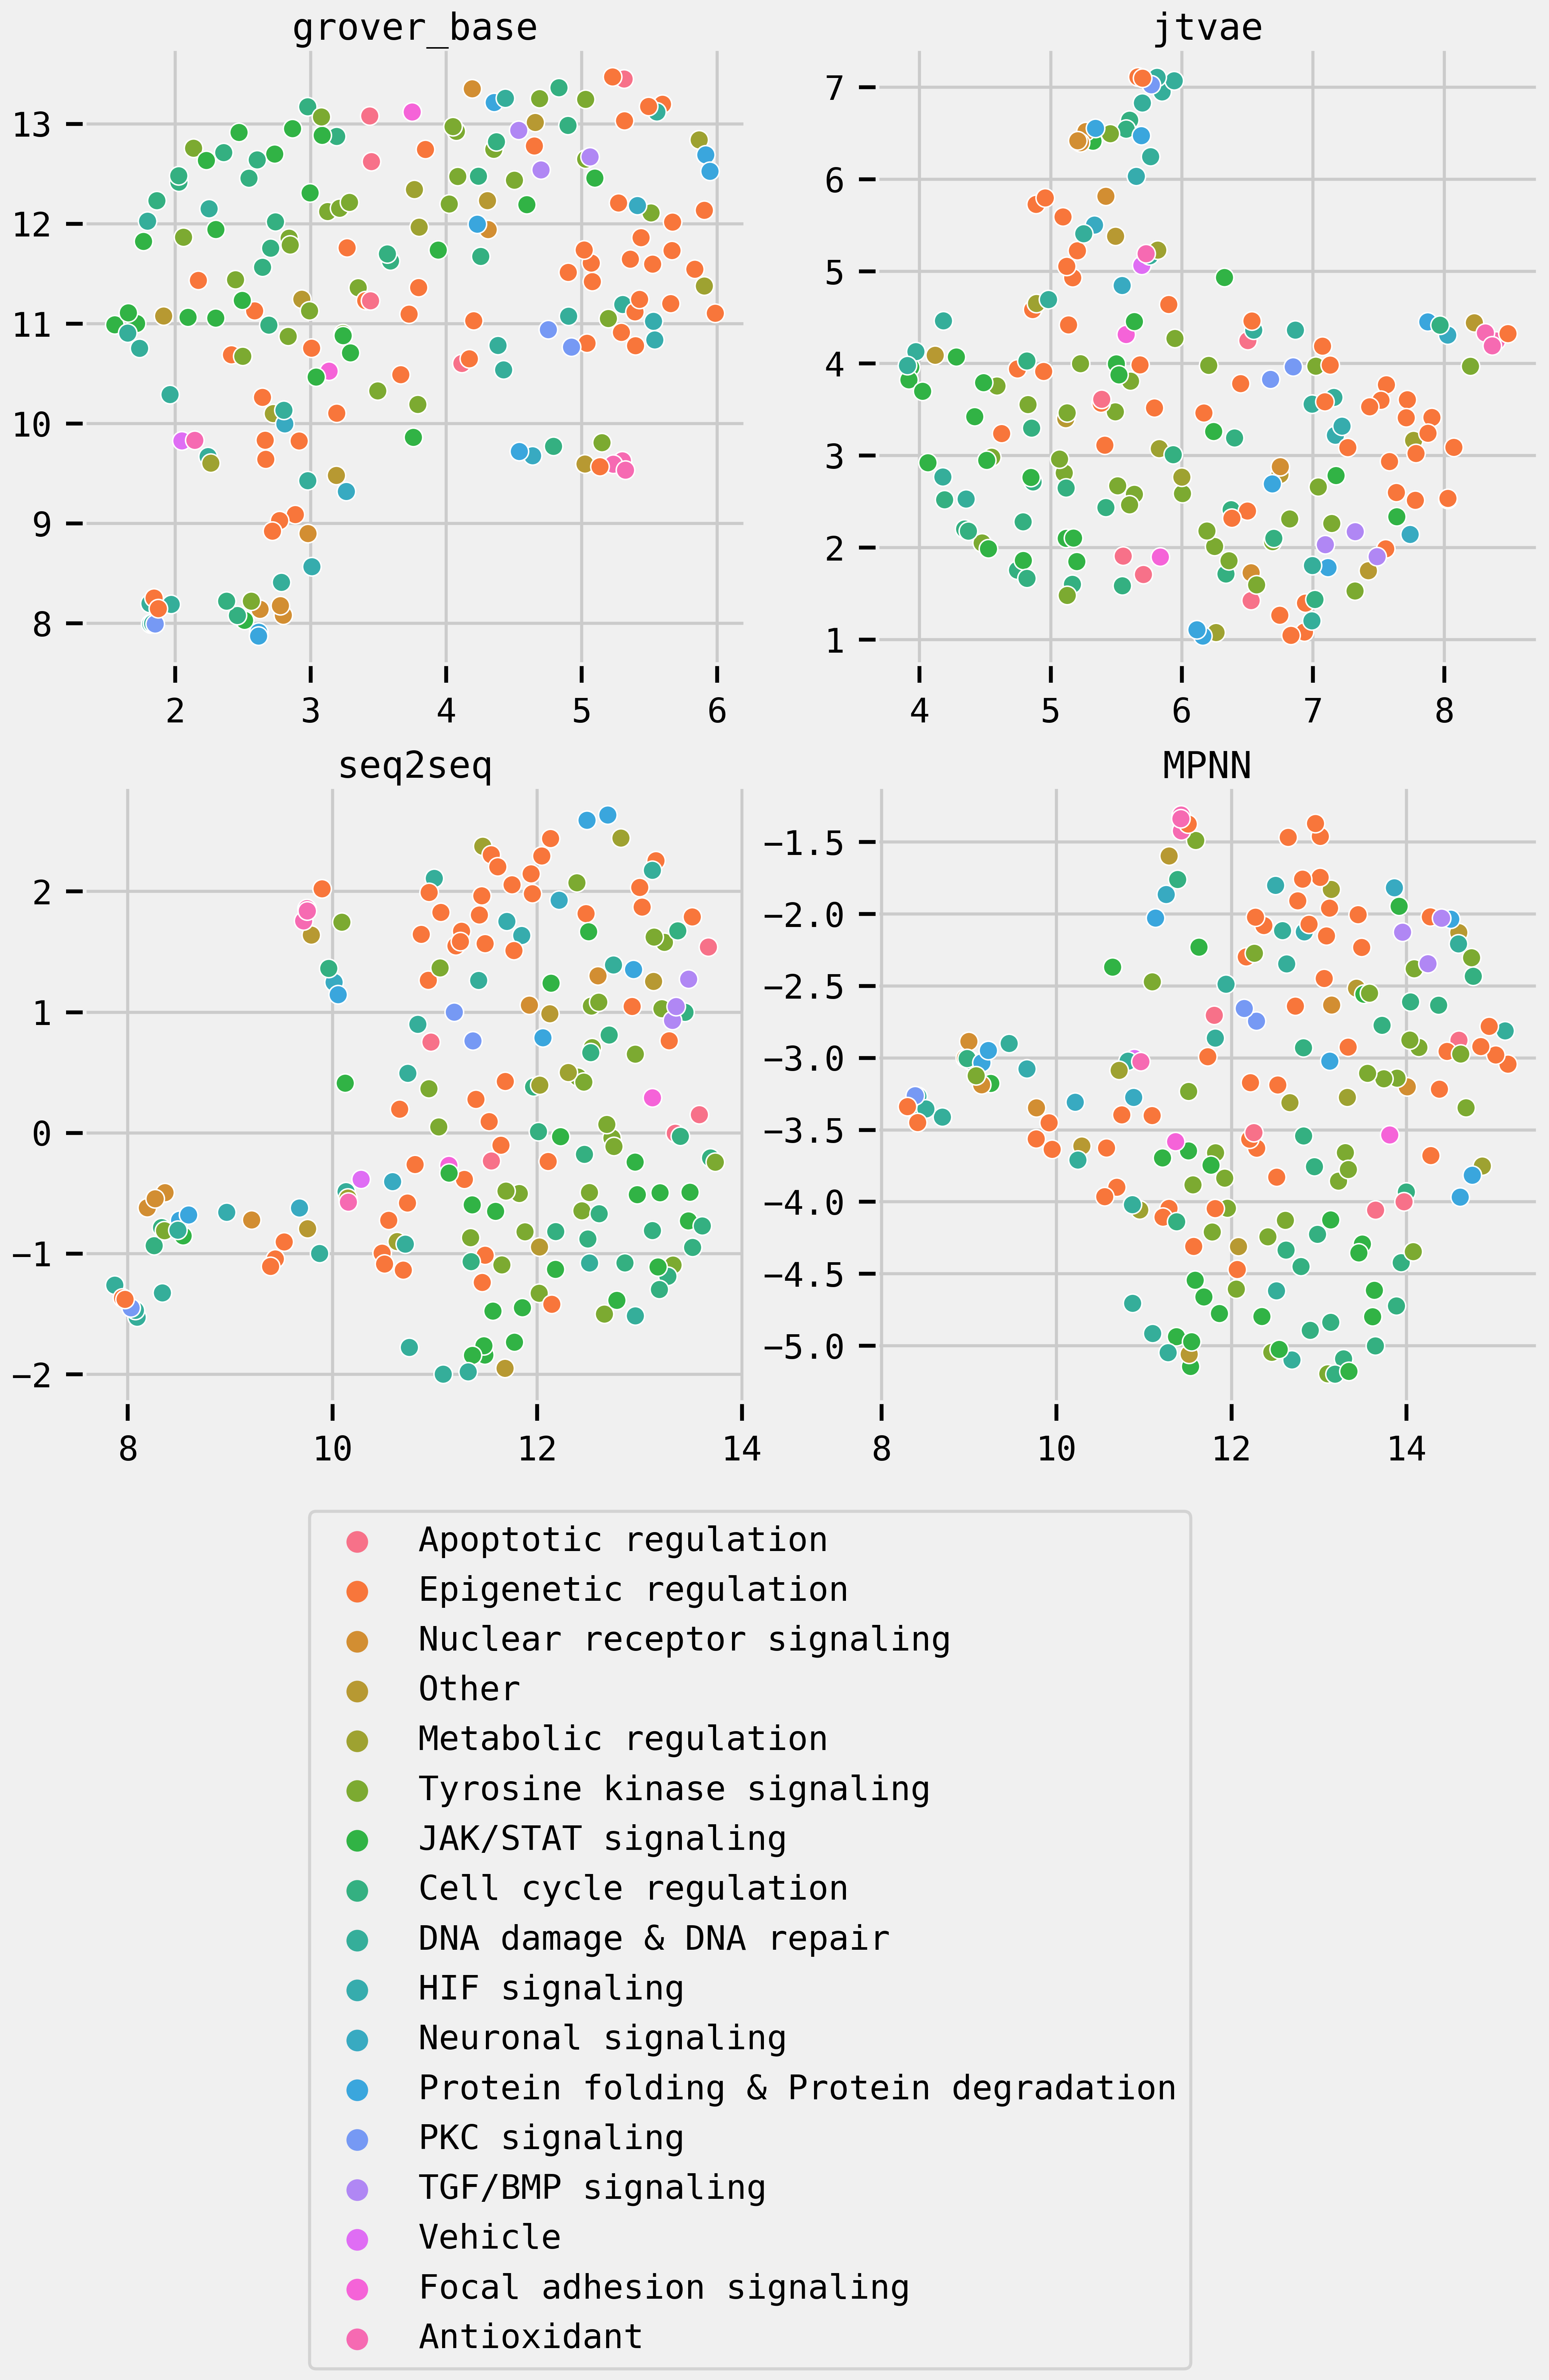

In [11]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, ((mapper, pathway), embedding) in enumerate(zip(mappers, embedding_names)):
    ax = sn.scatterplot(x=mapper[:,0], y=mapper[:,1], ax=axs[i // 2][i%2], hue=pathway)
    ax.set_title(embedding)
    if i == 3:
        # legend on the right
        # bbox = (1.05, 2.05)
        # legend below
        bbox = (0.5, -0.15)
        plt.legend(bbox_to_anchor=bbox)
    else:
        ax.get_legend().remove()
figure = plt.gcf()
figure.savefig("../../Latex/figures/04_methods/UMAP_latent_embeddings.png", bbox_inches="tight")
plt.show()